# Analysis


In [125]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
p9.theme_set(p9.theme_linedraw()) # default theme

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# Manipulation 
from siuba import *

# Outliers
from adtk.data import validate_series
from adtk.transformer import DoubleRollingAggregate
from adtk.visualization import plot

## Load data

In [40]:
from src import utils
from datetime import datetime
conn = utils.connect_athena(path='../configs/athena.yaml')
df = pd.read_sql_query("""
select 
    *,
    date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
from spd_sdv_waze_corona.prod_daily_daily_index
where country_iso_code = 'MX' and region_slug = 'country_mexico'
""", conn)

In [73]:
df_dow = (df
 >> select( 'region_slug', 'date',  'dow', 'observed', 'tcp') 
 >> mutate( aux_var = (_.dow == 1))
 >> arrange(_.region_slug, _.date)
 >> group_by('region_slug')
 >> mutate( week = _.aux_var.cumsum())
 >> ungroup()
 >> group_by('region_slug', 'week')
 >> mutate( min_date = _.date.min())
 >> ungroup()
 >> select( 'region_slug', 'dow', 'date', 'min_date', 'week', 'observed', 'tcp')
 >> arrange('region_slug', 'dow', 'date')
 >> group_by('region_slug', 'dow')
 >> mutate(tcp_ma = _.tcp.rolling(3).mean(),
           obs_ma = _.observed.rolling(3).mean())
 >> ungroup()          
).dropna()
df_dow['log_observed'] = np.log(df_dow['observed'])
df_dow.head(2)

,region_slug,dow,date,min_date,week,observed,tcp,tcp_ma,obs_ma,log_observed
2,country_mexico,1,2020-03-23,2020-03-23,3,163833694,-56.230493,-43.191844,212638677.0,18.914362
3,country_mexico,1,2020-03-30,2020-03-30,4,149716817,-60.001932,-49.903561,187516042.0,18.824256


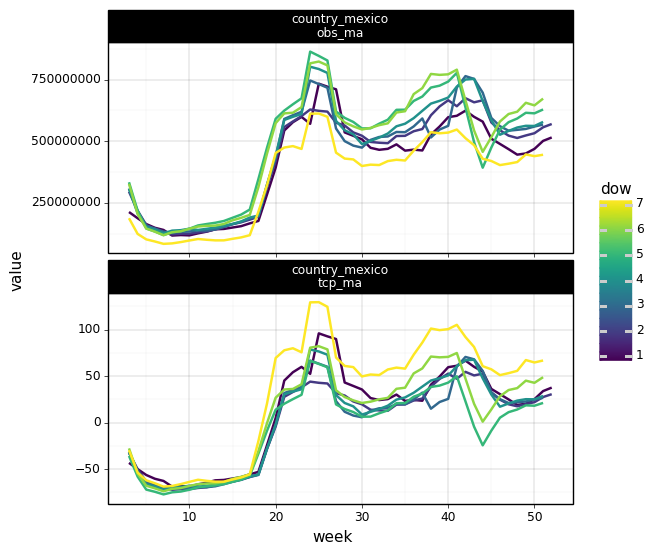

<ggplot: (8757142394901)>

In [96]:
(p9.ggplot(data=(df_dow
                 >> select('region_slug', 'dow', 'date', 'week', 
                           'tcp_ma', 'obs_ma')
                 >> gather('measure', 'value', _["tcp_ma", "obs_ma"])),
           mapping=p9.aes(x='week', y='value', 
                          color = 'dow', group = 'dow')) 
    + p9.geom_line(size=1) 
    + p9.facet_wrap(['region_slug', 'measure'], ncol = 1, scales='free') 
    + p9.theme(figure_size = (6, 6),
                axis_text_x=p9.element_text(angle=0)) )

In [59]:
tab = (df_dow
 >> group_by('region_slug', 'dow')
 >> summarize(n_obs = _.min_date.count())
 >> ungroup()
)
spread(tab, 'dow', 'n_obs')

,region_slug,1,2,3,4,5,6,7
0,country_mexico,52,52,51,51,51,51,51


In [102]:
# train sample
y_df = df_dow \
    .siu_arrange('date') \
    .siu_select('date', 'tcp_ma') \
    .set_index('date')
print(y_train.shape)

(345, 1)


In [104]:
s = validate_series(y_df)

In [112]:
s.head()

,tcp_ma
date,
2020-03-23,-43.191844
2020-03-24,-32.347992
2020-03-25,-31.136785
2020-03-26,-31.884389
2020-03-27,-35.720168


In [122]:
s_transformed = DoubleRollingAggregate(
    agg="mean",
    window=(3,1), #The tuple specifies the left window to be 3, and right window to be 1
    diff="l1").transform(s).rename(columns={"tcp_ma": "tcp_ma_tr"})

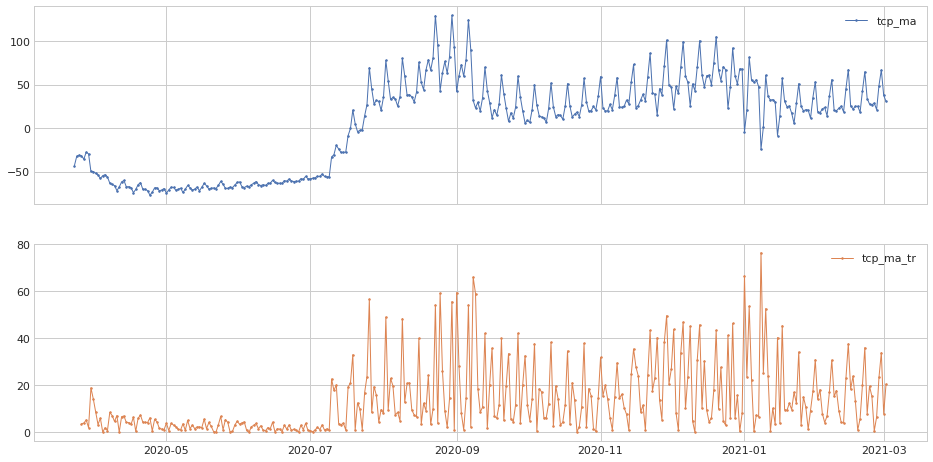

In [126]:
plot(pd.concat([s, s_transformed], axis=1), ts_linewidth=1, ts_markersize=3);